In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import random as rd
import datetime
import matplotlib.pyplot as plt

In [2]:
# Input
start = datetime.datetime( 2016, 7, 1)
end = datetime.datetime( 2016, 7, 7, 23, 59, 0)
interval = 300 # interval of market operation
file_WS = 'Ercot_LZ_SOUTH.csv'

In [3]:
market_intervals = pd.date_range(start,end,freq=str(int(interval/60))+'min')
print(len(market_intervals))

2016


In [4]:
df_WS = pd.read_csv(file_WS,parse_dates=True,index_col=[0]) # For year 2016
df_WS = df_WS[~df_WS.index.duplicated(keep='last')]

#change units, divide by 1000
# $/MWh * 1 MWh/1000 kWh = $/kWh
df_WS = df_WS/1000

df_WS = df_WS.loc[market_intervals] # update df_WS to be only relevant week
df_WS

,DA,RT
2016-07-01 00:00:00,0.01936,0.01948
2016-07-01 00:05:00,0.01936,0.01948
2016-07-01 00:10:00,0.01936,0.01948
2016-07-01 00:15:00,0.01936,0.01992
2016-07-01 00:20:00,0.01936,0.01992
...,...,...
2016-07-07 23:35:00,0.01967,0.01836
2016-07-07 23:40:00,0.01967,0.01836
2016-07-07 23:45:00,0.01967,0.01790
2016-07-07 23:50:00,0.01967,0.01790


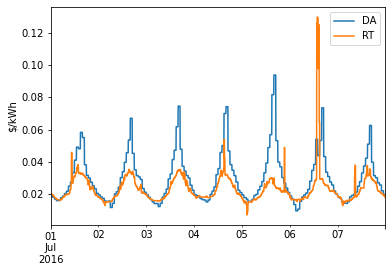

In [5]:
# plot for visual checking
df_WS.plot(ylabel="$/kWh");

## since price is converted to $/kWh, assume that battery storage = 5 kWh and battery power = 1 kW

## initial result: battery efficiency=99% and min storage=1

In [6]:
# Initialize parameters
prices = df_WS["RT"]
T = len(prices)

# Initialize variables
SOC = cp.Variable((T+1,))
x = cp.Variable((T,))

# Initialize constraints
constraints = [SOC[0]==2.]
constraints += [SOC[T]==2.]

for t in range(T):
    constraints += [x[t]>=-1., x[t]<=1., 1.<=SOC[t], SOC[t]<=5., SOC[t+1]==0.99*SOC[t]+(x[t]/12)] 
    #! 1% losses between time periods
    # x: positive --> charging (buying), negative --> discharging (selling)
    
# Objective function
obj = cp.sum(cp.multiply(prices,-x)) # Discharging : x < 0 --> positive profits

obj = cp.Maximize(obj)

In [7]:
# Solve problem
prob = cp.Problem(obj, constraints)
profits = (prob.solve())/12 #returns optimal value = prob.value
print(profits)

-0.2731500275510211


In [8]:
def visualize_battery_dispatch(SOC,x,prices,market_intervals):
    # Visualize battery dispatch over time as well as the market price
    fig = plt.figure(figsize=(9,3),dpi=150) 
    ax = fig.add_subplot(111)
    
    #plot1 = ax.plot(data.timestamp, data.RT, color='xkcd:sky blue', label='RT')
    #plot1 = ax.step(data.timestamp, data.RT, where="post", color='xkcd:sky blue', label='RT')
    plot1 = ax.step(market_intervals, prices, where="post", color='xkcd:sky blue', label='RT')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Real-time price (USD/MWh)')
#    ax.set_xlim(xmin=data.iloc[0]['timestamp'], xmax=data.iloc[-1]['timestamp']+pd.Timedelta(days=1))
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
#    ax.set_ylim(-1,5)

    ax2 = ax.twinx()
    #plot2 = ax2.plot(data.timestamp, data.SOC_t, color='orange', label='SOC')
    plot2 = ax2.step(market_intervals, SOC.value[:-1], where="post", color='orange', label='SOC')
    ax2.set_ylabel('State of Charge')
    ax2.set_ylim(-4,10)
    
    
    ax3 = ax.twinx()
    rspine = ax3.spines['right']
    rspine.set_position(('axes', 1.15))
    ax3.set_frame_on(True)
    ax3.patch.set_visible(False)
    fig.subplots_adjust(right=0.7)

    #plot3 = ax3.plot(data.timestamp, data.dispatch, color='red', label='load')
    plot3 = ax3.step(market_intervals, x.value, where="post", color='red', label='load')
    ax3.set_ylabel('Load Dispatched')
    ax3.set_ylim(-8,2)


    plots = plot1 + plot2 + plot3
    labs = [l.get_label() for l in plots]
    L = ax.legend(plots, labs, bbox_to_anchor=(0.5, -0.4), loc='lower center', ncol=len(labs))

<ipython-input-8-e4f728fdd651>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)


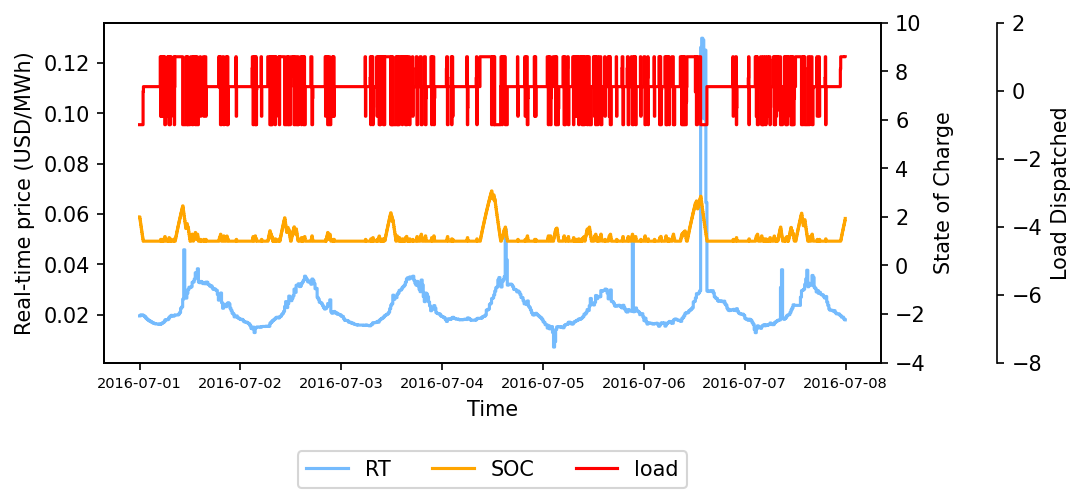

In [9]:
visualize_battery_dispatch(SOC,x,prices,market_intervals)

In [10]:
def visualize_price_and_SOC(SOC,prices,market_intervals,x):
    fig = plt.figure(figsize=(9,3),dpi=150) 
    
    ax = fig.add_subplot(111)
    plot1 = ax.step(market_intervals, prices, where="post", color='xkcd:sky blue', label='RT')
    ax.set_xlabel('Time')
    ax.set_ylabel('Real-time price (USD/kWh)')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

    ax2 = ax.twinx()
    plot2 = ax2.step(market_intervals, SOC.value[:-1], where="post", color='orange', label='SOC')
    ax2.set_ylabel('State of Charge (kWh)')
    
    ax3 = ax.twinx()
    rspine = ax3.spines['right']
    rspine.set_position(('axes', 1.15))
    ax3.set_frame_on(True)
    ax3.patch.set_visible(False)
    fig.subplots_adjust(right=0.7)
    
    cum_profits = np.cumsum(-x.value*prices)
    plot3 = ax3.step(market_intervals, cum_profits, where="post", color='green', label='Profits')
    ax3.set_ylabel("Profits (USD)")

    plots = plot1 + plot2 + plot3
    labs = [l.get_label() for l in plots]
    L = ax.legend(plots, labs, bbox_to_anchor=(0.5, -0.4), loc='lower center', ncol=len(labs))

<ipython-input-10-db9ff40f03b2>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)


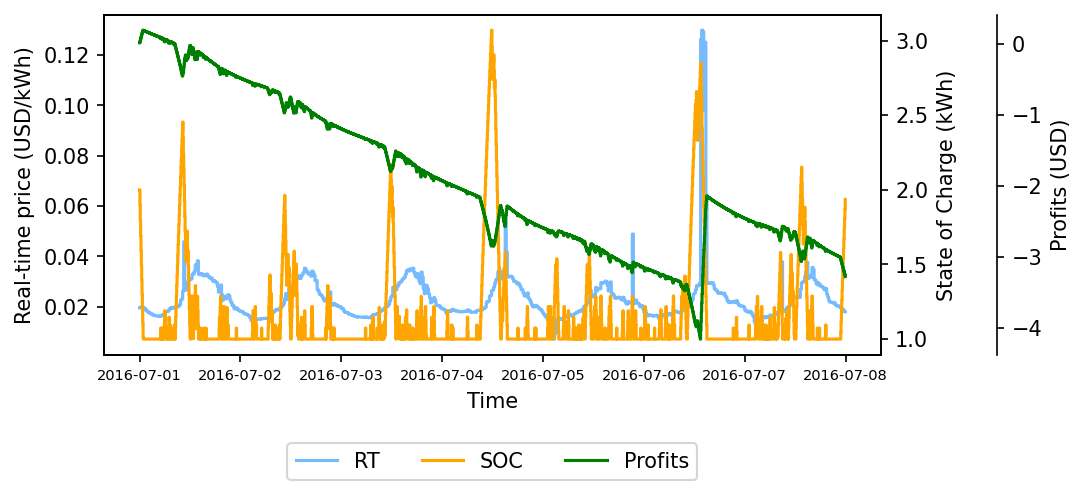

In [11]:
visualize_price_and_SOC(SOC,prices,market_intervals,x);

## Observations

- SOC never reaches its maximum value of 5
    - 1% losses per interval depress charge too much
- dispatch is not neatly correlated with RT price
- profits continually decrease
    - maximum profit is **negative**

## Logic check 

- SOC cannot sit at 0 due to losses
    - due to lower constraint on SOC and losses, the battery needs to continually buy from the market to recharge --> losses
    - even if dispatch = 0 over time, SOC will diminish and battery will need to buy at the end so that SOC[T]=2
- even worse, SOC must not be below 1, so battery cannot avoid losses

### here, I will set the battery efficiency=100% and the minimum charge to 0

In [12]:
# Initialize parameters
prices = df_WS["RT"]
T = len(prices)

# Initialize variables
SOC = cp.Variable((T+1,))
x = cp.Variable((T,))

# Initialize constraints
constraints = [SOC[0]==2.]
constraints += [SOC[T]==2.]

for t in range(T):
    constraints += [x[t]>=-1., x[t]<=1., 0.<=SOC[t], SOC[t]<=5., SOC[t+1]==1.00*SOC[t]+(x[t]/12)] 
    
# Objective function
obj = cp.sum(cp.multiply(prices,-x)) # Discharging : x < 0 --> positive profits

obj = cp.Maximize(obj)

In [13]:
# Solve problem
prob = cp.Problem(obj, constraints)
profits = (prob.solve())/12 #returns optimal value = prob.value
print(profits)

0.6959099999615977


<ipython-input-10-db9ff40f03b2>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)


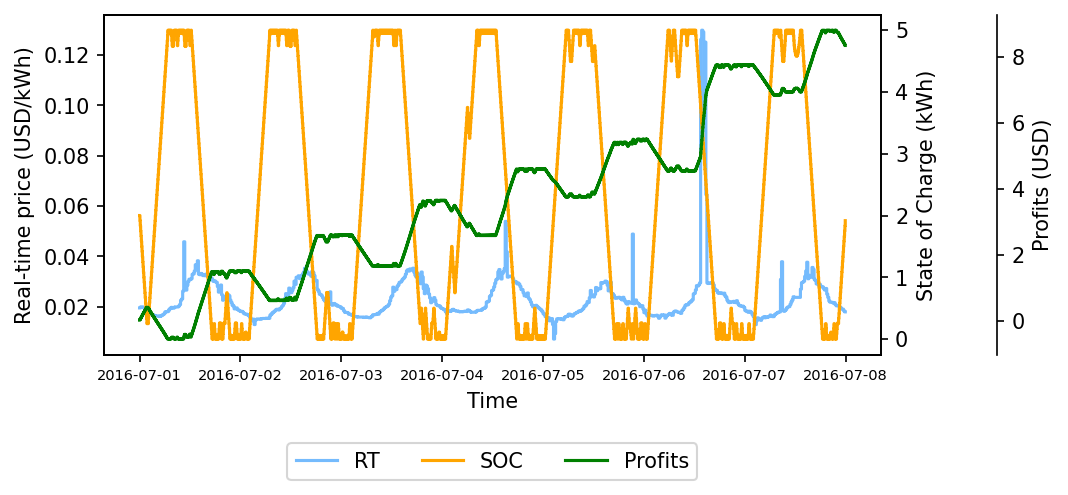

In [14]:
visualize_price_and_SOC(SOC,prices,market_intervals,x);

- This is a more expected result 
- SOC oscillates between its min and max charge
- battery holds charge for longer periods of time
    - diurnal arbitrage
- profits rise the most during times of increasing prices
    - profits positive!